Data 201 Project #3 Decision Trees

Austin Animal Center Shelter Intakes and Outcomes. 
This analysis focuses on the gender and age of animals successfully adopted from the shelter.

In [0]:
# import packages
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import plot_tree

import matplotlib.pyplot as plt
import seaborn as sns


In [0]:
import graphviz
from sklearn.tree import export_graphviz
from IPython.display import display

The data is available on kaggle in a few different versions. I chose data that had been cleaned a bit already. The data is available here https://www.kaggle.com/aaronschlegel/austin-animal-center-shelter-outcomes-and#aac_shelter_outcomes.csv 

In [249]:
# read in the dataset
shelterdf = pd.read_csv('aac_shelter_outcomes.csv')
shelterdf.shape

(78256, 12)

This shelter dataset includes 78,256 records and 12 features/variables. 

In [250]:
shelterdf.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,Unknown


In [251]:
shelterdf.dtypes

age_upon_outcome    object
animal_id           object
animal_type         object
breed               object
color               object
date_of_birth       object
datetime            object
monthyear           object
name                object
outcome_subtype     object
outcome_type        object
sex_upon_outcome    object
dtype: object

I'll start with some EDA to visualize the data. I'll make a histogram. 

In [0]:
shelterdf['outcome_type'] = shelterdf['outcome_type'].astype('str') # converts the column to string
shelterdf['animal_type'] = shelterdf['animal_type'].astype('str') # converts the column to string

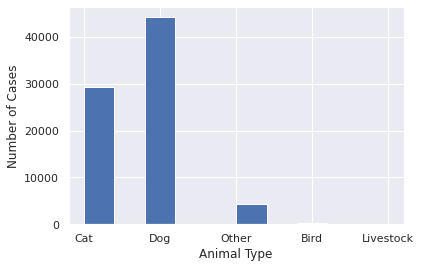

In [253]:
sns.set()
_ = plt.hist(shelterdf['animal_type'])
_ = plt.xlabel('Animal Type')
_ = plt.ylabel('Number of Cases')
plt.show()

The histogram shows the highest number of animals processed at the shelter are dogs.

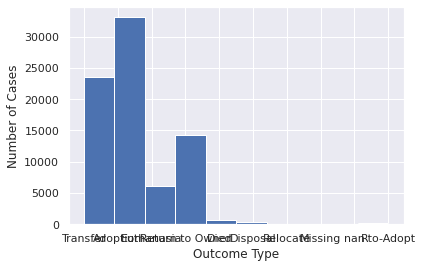

In [254]:
sns.set()
_ = plt.hist(shelterdf['outcome_type'])
_ = plt.xlabel('Outcome Type')
_ = plt.ylabel('Number of Cases')
plt.show()

This histogram is too crowded but the highest counts are Adoption, Transfer, Return to Owner, and Euthanasia, respectively. 

I'll create a new variable "age" from the (datetime - date of birth). This will be in the units "days" so adding the map & lambda functions clear the timestamp so it is an integer.

The map function has 2 arguments: map (func, seq) where the function applies to all the elements of the sequence. It returns a new list with the elements that have been changed by the function.

The lambda function creates a function without a name so it is only used where it is created. Programmers like to use the lambda function with other functions like map, filter, or reduce. 

In [0]:
shelterdf = shelterdf.assign(age=(pd.to_datetime(shelterdf['datetime']) - pd.to_datetime(shelterdf['date_of_birth'])).map(lambda v: v.days))
# This uses the age as the datetime minus the DOB, in days, and creates the variable age as an integer. 

In [256]:
shelterdf.dtypes

age_upon_outcome    object
animal_id           object
animal_type         object
breed               object
color               object
date_of_birth       object
datetime            object
monthyear           object
name                object
outcome_subtype     object
outcome_type        object
sex_upon_outcome    object
age                  int64
dtype: object

In [257]:
shelterdf.describe(include='all')

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome,age
count,78248,78256,78256,78256,78256,78256,78256,78256,54370,35963,78256,78254,78256.000000
unique,46,70855,5,2128,525,5869,64361,64361,14574,19,10,5,NaN
top,1 year,A706536,Dog,Domestic Shorthair Mix,Black/White,2014-05-05T00:00:00,2016-04-18T00:00:00,2016-04-18T00:00:00,Bella,Partner,Adoption,Neutered Male,NaN
freq,14355,11,44242,23335,8153,112,39,39,344,19660,33112,27784,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,817.034822
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1077.098289
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-123.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,371.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1096.000000


In [258]:
# select the features of interest 
shortshelterdf = (shelterdf.loc[:,['animal_type','breed','color','sex_upon_outcome','age']])
shortshelterdf.shape

(78256, 5)

I'll focus on these variables for the decision tree to see what features lead to an adoption outcome.

In [259]:
shortshelterdf.head() # the age is listed in days

,animal_type,breed,color,sex_upon_outcome,age
0,Cat,Domestic Shorthair Mix,Orange Tabby,Intact Male,15
1,Dog,Beagle Mix,White/Brown,Spayed Female,366
2,Dog,Pit Bull,Blue/White,Neutered Male,429
3,Dog,Miniature Schnauzer Mix,White,Neutered Male,3300
4,Other,Bat Mix,Brown,Unknown,181


The decision tree classifier will look for an integer (not an object) so we have to use a pandas function called "get_dummies" to change the categorical variables into a dummy or indicator variable (1 or 0, True or False). 

Converting the dataframe this way also flips it wide versus long.

Since the age is listed in days, I can convert this to years by dividing by 365. 

In [0]:
shortshelterdummiesdf = pd.get_dummies(shortshelterdf[['animal_type','breed','color','sex_upon_outcome']]).assign(age=shortshelterdf['age'] / 365)

In [261]:
shortshelterdummiesdf.head()

,animal_type_Bird,animal_type_Cat,animal_type_Dog,animal_type_Livestock,animal_type_Other,breed_Abyssinian Mix,breed_Affenpinscher Mix,breed_Afghan Hound Mix,breed_Afghan Hound/Labrador Retriever,breed_African Mix,breed_Airedale Terrier,breed_Airedale Terrier Mix,breed_Airedale Terrier/Irish Terrier,breed_Airedale Terrier/Labrador Retriever,breed_Airedale Terrier/Miniature Schnauzer,breed_Akbash Mix,breed_Akita,breed_Akita Mix,breed_Akita/Australian Cattle Dog,breed_Akita/Belgian Malinois,breed_Akita/Border Collie,breed_Akita/Chow Chow,breed_Akita/German Shepherd,breed_Akita/Great Pyrenees,breed_Akita/Labrador Retriever,breed_Akita/Mastiff,breed_Akita/Pit Bull,breed_Akita/Siberian Husky,breed_Alaskan Husky,breed_Alaskan Husky Mix,breed_Alaskan Husky/Australian Shepherd,breed_Alaskan Husky/Border Collie,breed_Alaskan Husky/German Shepherd,breed_Alaskan Husky/Labrador Retriever,breed_Alaskan Malamute,breed_Alaskan Malamute Mix,breed_Alaskan Malamute/Akita,breed_Alaskan Malamute/Alaskan Husky,breed_Alaskan Malamute/Australian Kelpie,breed_Alaskan Malamute/Border Collie,...,color_White/Gray Tiger,color_White/Green,color_White/Lilac Point,color_White/Liver,color_White/Liver Tick,color_White/Lynx Point,color_White/Orange,color_White/Orange Tabby,color_White/Pink,color_White/Red,color_White/Red Merle,color_White/Red Tick,color_White/Seal Point,color_White/Silver,color_White/Silver Tabby,color_White/Tan,color_White/Tortie,color_White/Tricolor,color_White/White,color_White/Yellow,color_White/Yellow Brindle,color_Yellow,color_Yellow Brindle,color_Yellow Brindle/Blue,color_Yellow Brindle/White,color_Yellow/Black,color_Yellow/Brown,color_Yellow/Cream,color_Yellow/Gray,color_Yellow/Orange,color_Yellow/Orange Tabby,color_Yellow/Tan,color_Yellow/White,color_Yellow/Yellow,sex_upon_outcome_Intact Female,sex_upon_outcome_Intact Male,sex_upon_outcome_Neutered Male,sex_upon_outcome_Spayed Female,sex_upon_outcome_Unknown,age
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.041096
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1.002740
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1.175342
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,9.041096
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.495890


The functions map and lambda are used in the code below to capture the records that have the outcome type called Adoption, as these are the records we are focusing on. We are using a decision tree to identify the factors (or features) that lead to the outcome called Adoption (as opposed to an outcome of transfer, return to owner, euthanasia, etc.) The code below assigns the y variable as the records with the outcome "Adoption".

In [0]:
X = shortshelterdummiesdf
# I'll go back to the larger dataframe to pull the outcome type
y = shelterdf.outcome_type.map(lambda v: v =="Adoption") 

In [263]:
X.head()

,animal_type_Bird,animal_type_Cat,animal_type_Dog,animal_type_Livestock,animal_type_Other,breed_Abyssinian Mix,breed_Affenpinscher Mix,breed_Afghan Hound Mix,breed_Afghan Hound/Labrador Retriever,breed_African Mix,breed_Airedale Terrier,breed_Airedale Terrier Mix,breed_Airedale Terrier/Irish Terrier,breed_Airedale Terrier/Labrador Retriever,breed_Airedale Terrier/Miniature Schnauzer,breed_Akbash Mix,breed_Akita,breed_Akita Mix,breed_Akita/Australian Cattle Dog,breed_Akita/Belgian Malinois,breed_Akita/Border Collie,breed_Akita/Chow Chow,breed_Akita/German Shepherd,breed_Akita/Great Pyrenees,breed_Akita/Labrador Retriever,breed_Akita/Mastiff,breed_Akita/Pit Bull,breed_Akita/Siberian Husky,breed_Alaskan Husky,breed_Alaskan Husky Mix,breed_Alaskan Husky/Australian Shepherd,breed_Alaskan Husky/Border Collie,breed_Alaskan Husky/German Shepherd,breed_Alaskan Husky/Labrador Retriever,breed_Alaskan Malamute,breed_Alaskan Malamute Mix,breed_Alaskan Malamute/Akita,breed_Alaskan Malamute/Alaskan Husky,breed_Alaskan Malamute/Australian Kelpie,breed_Alaskan Malamute/Border Collie,...,color_White/Gray Tiger,color_White/Green,color_White/Lilac Point,color_White/Liver,color_White/Liver Tick,color_White/Lynx Point,color_White/Orange,color_White/Orange Tabby,color_White/Pink,color_White/Red,color_White/Red Merle,color_White/Red Tick,color_White/Seal Point,color_White/Silver,color_White/Silver Tabby,color_White/Tan,color_White/Tortie,color_White/Tricolor,color_White/White,color_White/Yellow,color_White/Yellow Brindle,color_Yellow,color_Yellow Brindle,color_Yellow Brindle/Blue,color_Yellow Brindle/White,color_Yellow/Black,color_Yellow/Brown,color_Yellow/Cream,color_Yellow/Gray,color_Yellow/Orange,color_Yellow/Orange Tabby,color_Yellow/Tan,color_Yellow/White,color_Yellow/Yellow,sex_upon_outcome_Intact Female,sex_upon_outcome_Intact Male,sex_upon_outcome_Neutered Male,sex_upon_outcome_Spayed Female,sex_upon_outcome_Unknown,age
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.041096
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1.002740
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1.175342
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,9.041096
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.495890


Now we need to classify our data using the package sklearn.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=1)

In [265]:
dt = DecisionTreeClassifier(max_depth=3)

# fit the decision tree to the training set
dt.fit(X_train, y_train)

# predict test set
y_predicted = dt.predict(X_test)

# compute test set accuracy
acc = accuracy_score(y_predicted, y_test)
print(acc)

0.7457511607104826


The accuracy score is about 75% so the model explains about 75% of the variability which is pretty good. The closer to 100%, the higher the accuracy in predicting the output.

I'll use the graphviz function to make a tree graph. 


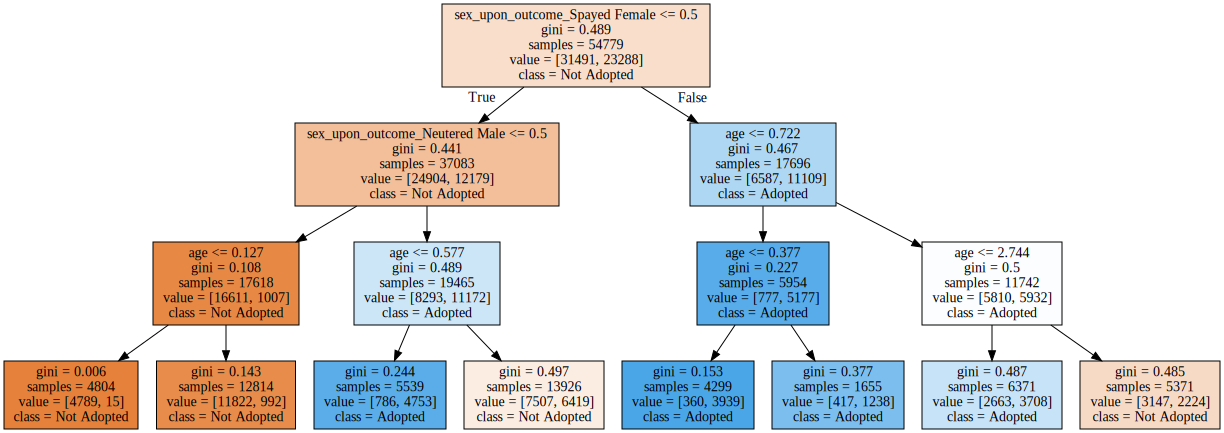

In [266]:
treedata = export_graphviz(dt, out_file = None, feature_names = X.columns, class_names = ['Not Adopted', 'Adopted'], filled = True)
treegraph = graphviz.Source(treedata)
display(treegraph)

The decision tree starts with spayed females which has the largest gini value of 0.489. 


Another way to create a tree plot.

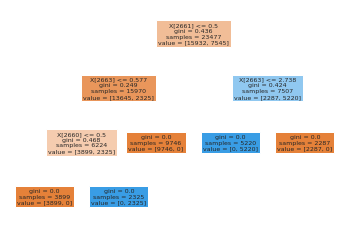

In [267]:
plt.figure()
clf = DecisionTreeClassifier().fit(X_test, y_predicted)
plot_tree(clf, filled=True)
plt.show()

Trying to go about this a different way. 

In [0]:
X1 = shortshelterdf
codes = {'Adopted':1, 'Return to Owner':2, 'Transfer':3, 'Euthanasia':4, 'Died':5, 'Rto-Adopt':6, 'Disposal':7, 'Missing':8}
y1 = shelterdf.outcome_type.map(codes) 

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size = .3, random_state=1)

In [270]:
dt = DecisionTreeClassifier(max_depth=3) # this says we are using a tree with 3 decision layers

# fit the decision tree to the training set
dt.fit(X_train, y_train)

# predict test set
y_predicted = dt.predict(X_test)

# compute test set accuracy
acc = accuracy_score(y_predicted, y_test)
print(acc)

ValueError: ignored